In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../utils/')
import lec2_graphs as afx

import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams["figure.figsize"] = (10, 6) # Tamaño gráficos
plt.rcParams["figure.dpi"] =100 # resolución gráficos
#sn.set_style('darkgrid')

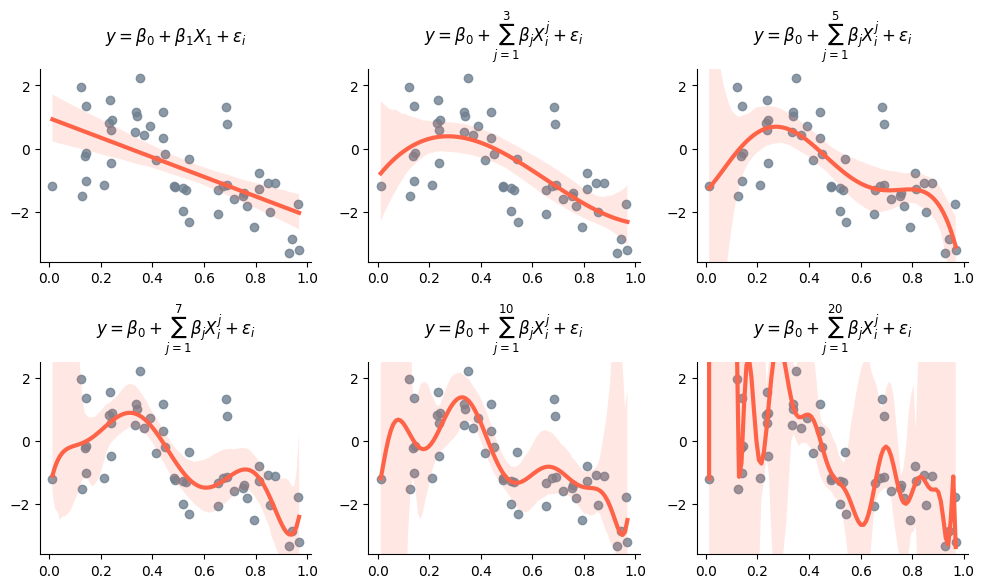

In [19]:
afx.polynomial_degrees()

In [20]:
df = pd.read_csv('kc_house_data.csv')

df.drop(['zipcode', 'id', 'date'], axis = 1, inplace = True)
X = df.loc[:,['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']]

In [21]:
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, df['price'], test_size =.3, random_state = 63)

scaler = StandardScaler().fit(X_train_pre)
X_train = pd.DataFrame(scaler.transform(X_train_pre), columns = X_train_pre.columns)
X_test = pd.DataFrame(scaler.transform(X_test_pre), columns = X_test_pre.columns)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [22]:
from pygam import LinearGAM
from pygam import s

lam = np.logspace(-3, 3, 3)
lams = [lam] * 4

gam = LinearGAM(s(0) + s(1) + s(2)+ s(3), fit_intercept=True)

In [23]:
gam.gridsearch(X_train.values, y_train.values, lam=lams)

  0% (0 of 81) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 81) |                         | Elapsed Time: 0:00:00 ETA:   0:00:29
  2% (2 of 81) |                         | Elapsed Time: 0:00:00 ETA:   0:00:30
  3% (3 of 81) |                         | Elapsed Time: 0:00:01 ETA:   0:00:30
  4% (4 of 81) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:29
  6% (5 of 81) |#                        | Elapsed Time: 0:00:02 ETA:   0:00:30
  7% (6 of 81) |#                        | Elapsed Time: 0:00:02 ETA:   0:00:31
  8% (7 of 81) |##                       | Elapsed Time: 0:00:02 ETA:   0:00:31
  9% (8 of 81) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:31
 11% (9 of 81) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:31
 12% (10 of 81) |##                      | Elapsed Time: 0:00:04 ETA:   0:00:29
 13% (11 of 81) |###                     | Elapsed Time: 0:00:04 ETA:   0:00:28
 14% (12 of 81) |###                    

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + intercept, tol=0.0001, 
   verbose=False)

In [24]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     50.5084
Link Function:                     IdentityLink Log Likelihood:                               -388710.4607
Number of Samples:                        15129 AIC:                                           777523.9383
                                                AICc:                                           777524.297
                                                GCV:                                      57794407073.9769
                                                Scale:                                    57447204678.7826
                                                Pseudo R-Squared:                                   0.5944
Feature Function                  Lam

In [25]:
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
def report_gam_metrics(model, X_test, y_test):
    print('Test R^2: {0}'.format(r2_score(y_test, model.predict(X_test)).round(3)))
    print('Test RMSE: {0}'.format(np.sqrt(mean_squared_error(y_test, model.predict(X_test))).round(3)))
    print('Test Median Absolute Error: {0}'.format(median_absolute_error(y_test, model.predict(X_test)).round(3)))

report_gam_metrics(gam, X_test, y_test)

Test R^2: 0.504
Test RMSE: 243684.196
Test Median Absolute Error: 120633.493


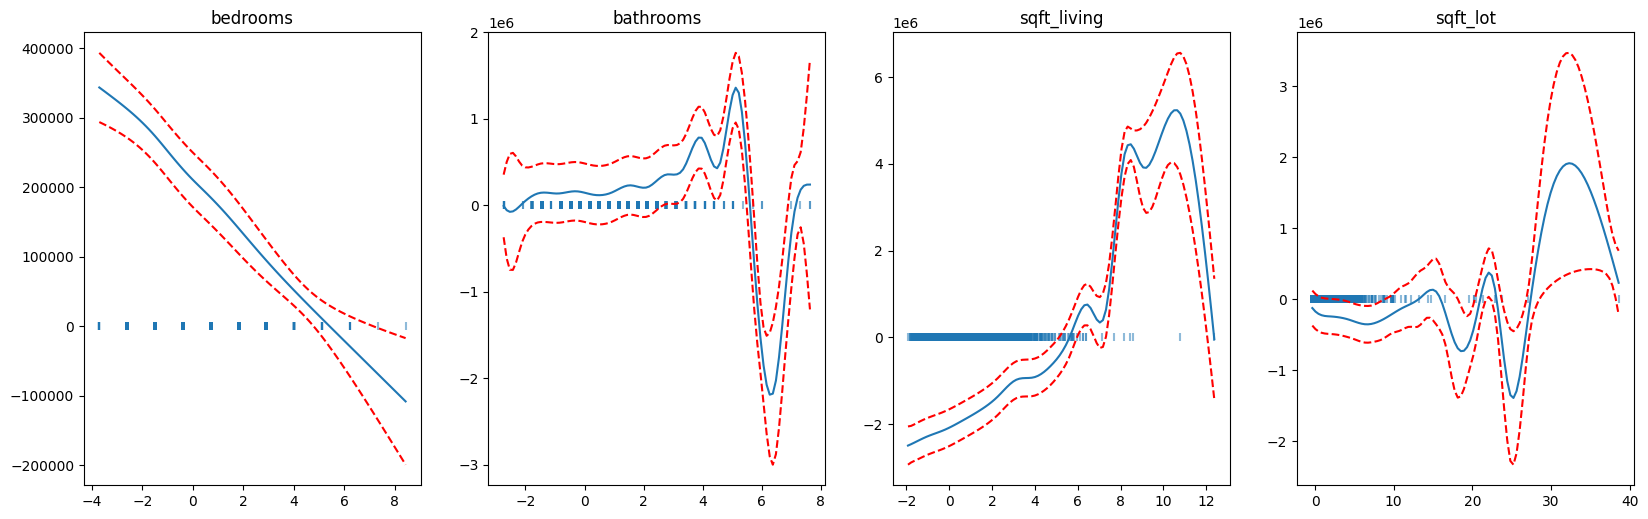

In [26]:
fig, axs = plt.subplots(1,4, figsize = (20,6));
titles = X_train.columns
for i, ax in enumerate(axs.flatten()):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.scatter(X_train[titles[i]], [0] * len(X_train[titles[i]]), marker = '|', alpha = .5) 
    ax.set_title(titles[i]);

In [28]:
new_gam = LinearGAM(lam = 1e6).fit(X_train, y_train)
report_gam_metrics(new_gam, X_test, y_test)

Test R^2: 0.482
Test RMSE: 249127.126
Test Median Absolute Error: 125551.637


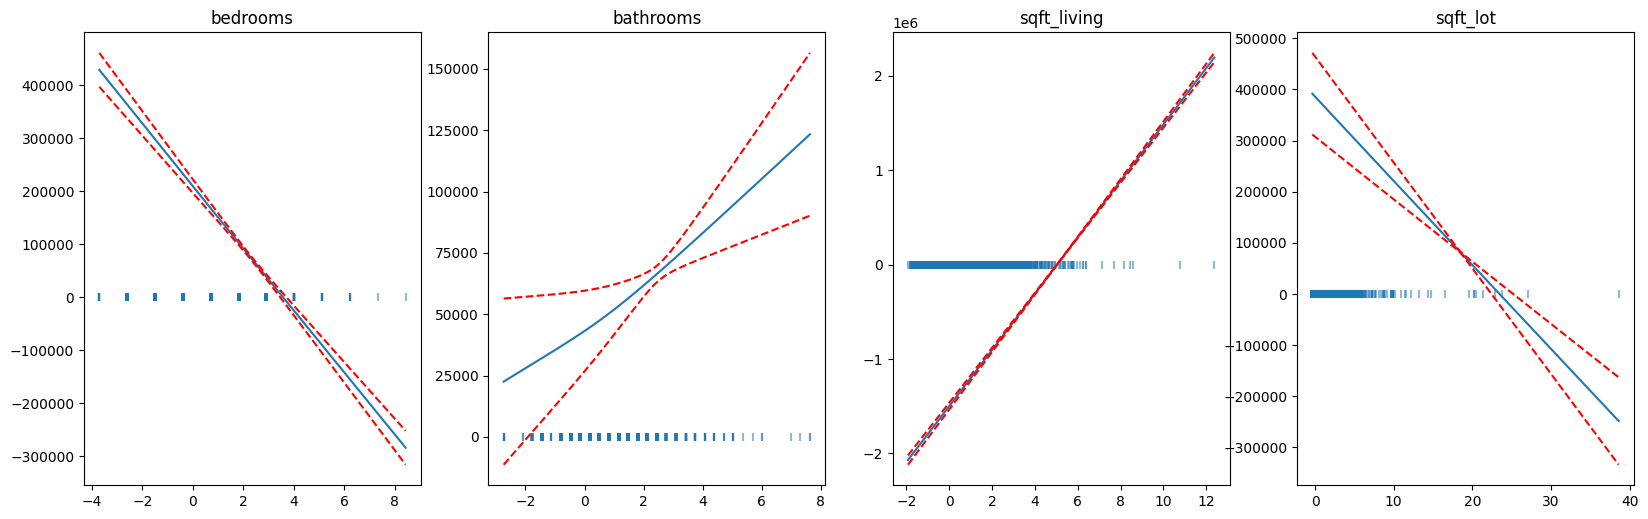

In [29]:
fig, axs = plt.subplots(1,4, figsize = (20,6));
titles = X_train.columns
for i, ax in enumerate(axs.flatten()):
    XX = new_gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], new_gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], new_gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.scatter(X_train[titles[i]], [0] * len(X_train[titles[i]]), marker = '|', alpha = .5)
    ax.set_title(titles[i]);

In [30]:
new_gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.0321
Link Function:                     IdentityLink Log Likelihood:                               -391242.5069
Number of Samples:                        15129 AIC:                                            782497.078
                                                AICc:                                          782497.0836
                                                GCV:                                      67953833386.0127
                                                Scale:                                     67913150496.327
                                                Pseudo R-Squared:                                    0.519
Feature Function                  Lam